In [192]:
%pylab inline
import pandas as pd
from sklearn import tree
from numpy import genfromtxt
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB

clf = tree.DecisionTreeClassifier(max_depth=8,max_leaf_nodes=50)
#clf = GaussianNB()
db = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat'
df = pd.read_csv(db, header=None, sep=' ')
arr = df.values

features = arr[:,0:14]
classes = arr[:,14]

X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=0.3, random_state=0)

clf = clf.fit(X_train, y_train)

Populating the interactive namespace from numpy and matplotlib


This time, I set the max depth of my tree to be 8, and max of leaf nodes to be 50, with the hope of avoiding overfitting and reaching better accuracy.

#### Generate Decision Tree

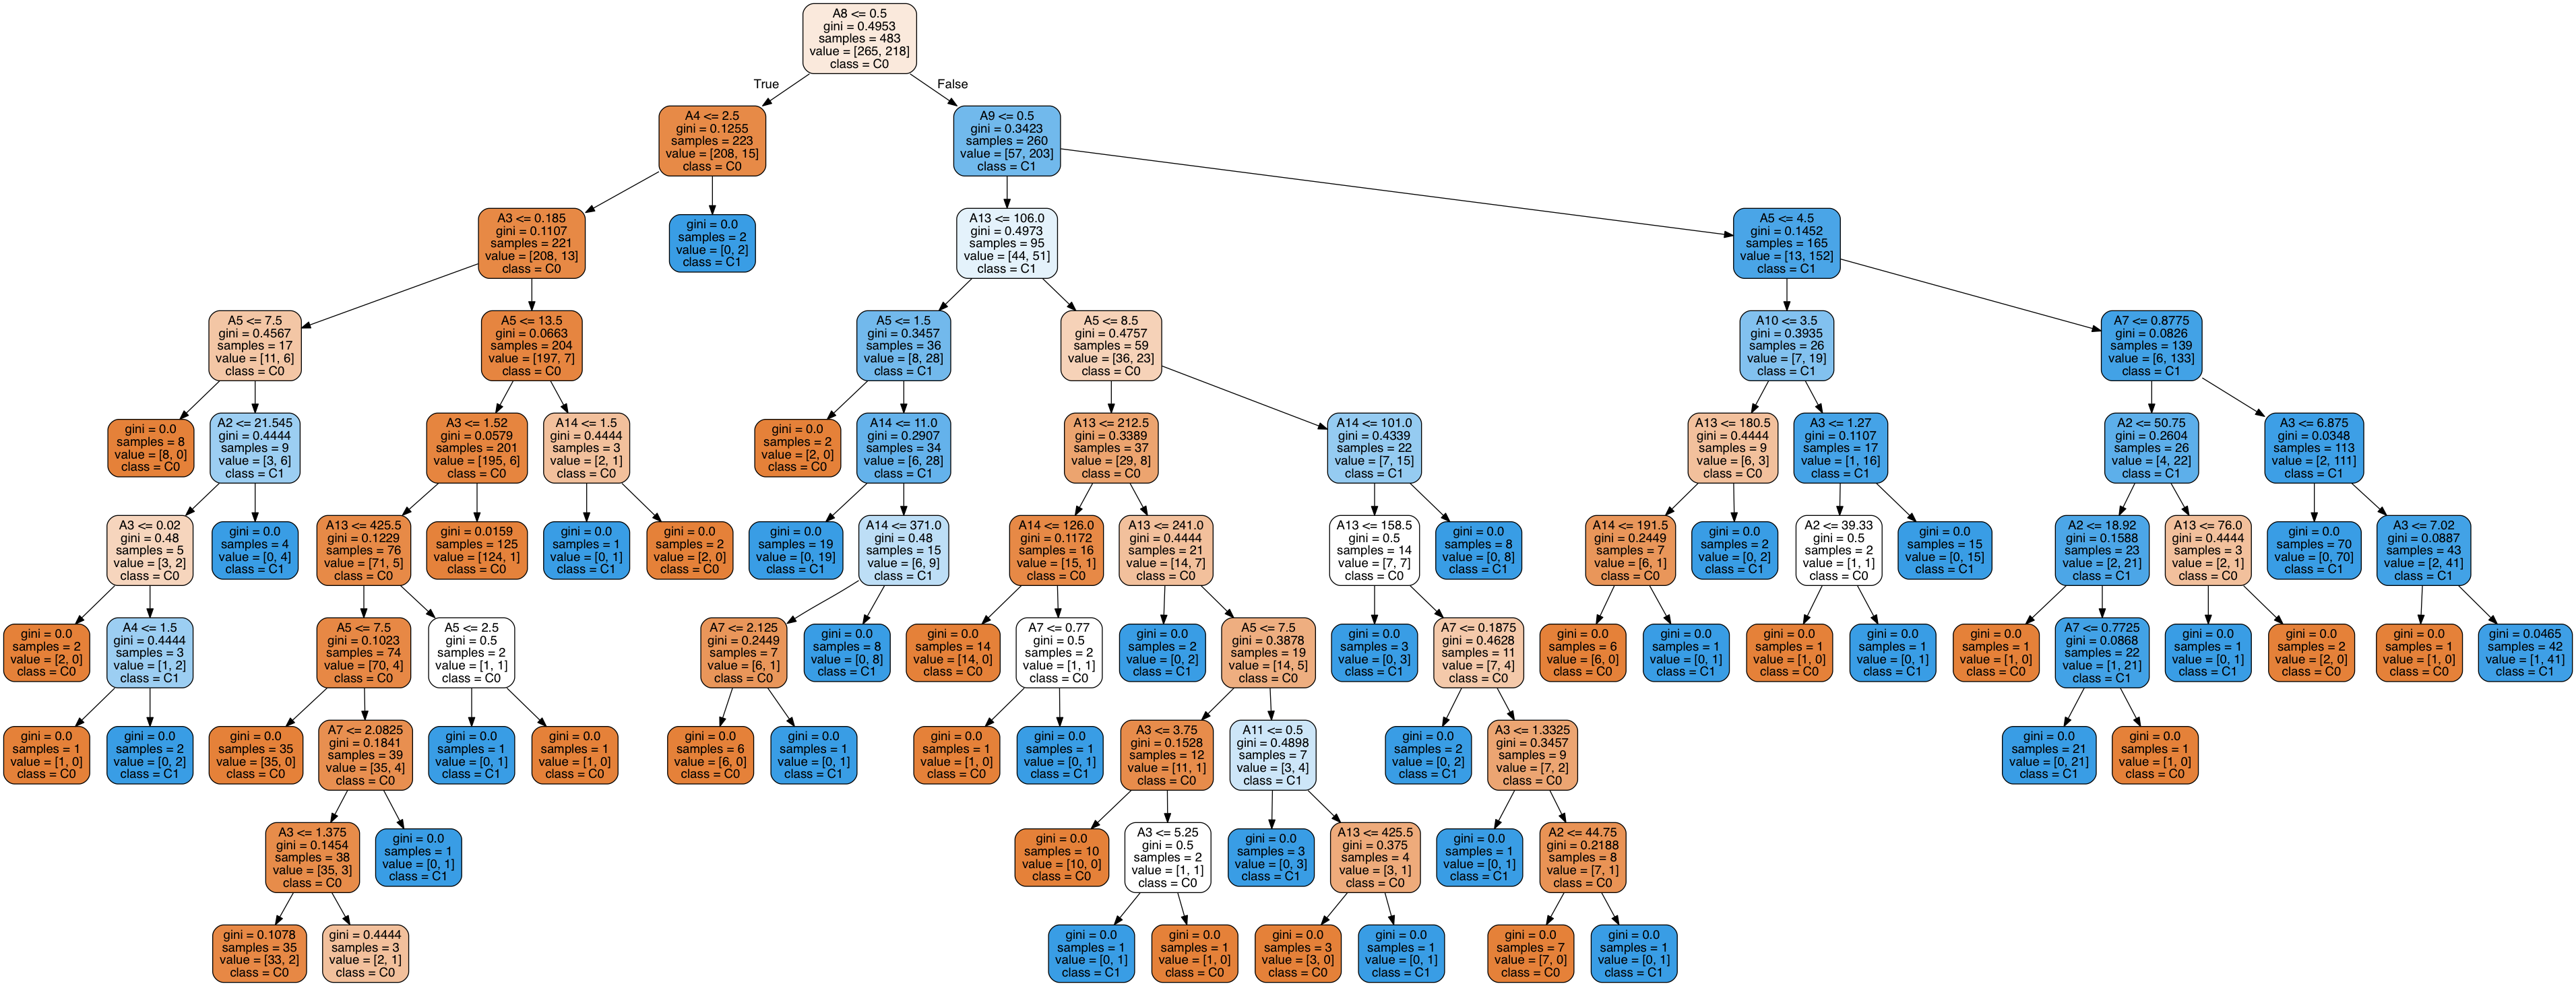

In [193]:
from IPython.display import Image  
import pydotplus

features = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']
class_names = ['C0', 'C1']

with open("tree2.dot", 'w') as f:
    f = tree.export_graphviz(clf, feature_names=features, class_names=class_names, filled=True, rounded=True, out_file=f)

graph = pydotplus.graph_from_dot_data(open('tree2.dot').read()) 
Image(graph.create_png()) 

#### Part 1: The accuracy of your model on the test data

In [194]:
num_total = num_correct = num_wrong = 0
predictions = clf.predict(X_test)
for i in xrange(len(predictions)):
    result = predictions[i]
    if result == y_test[i]:
        num_correct += 1
    else:
        num_wrong += 1
    num_total += 1
print 'Total number of testcases: %s \nTotal number of correct predictions: %s \nAccuracy: %f' % (num_total, num_correct, float(num_correct)/num_total)

Total number of testcases: 207 
Total number of correct predictions: 175 
Accuracy: 0.845411


In this dataset, I split the training part / testing part ratio to be 0.7 / 0.3. So about one third of the dataset is used as for testing. I also used Decisiontree classifier as the model, which is the same as what I used in assignment 7.

As we can see above, in total 207 of testing cases, 163 are correctly predicted by the model. The overall accuracy is 175 / 207 = 0.845411.

#### Part 2: The precision and recall values

In [195]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print 'Recall score is: %s' % recall_score(y_test, predictions, average='binary', pos_label=1) 
print 'Precision score is: %s' % precision_score(y_test, predictions, average='binary', pos_label=1) 

Recall score is: 0.831460674157
Precision score is: 0.813186813187


From lecture definition, recall = TP / TP + FN. Precision = TP / TP + FP. In the above code, I used recall_score and precision_score function available in sklearn to conveniently compute both values.

In this specific case, my recall score is 0.83, and my precision score is 0.81 which is slightly lower than the recall score. 

#### Part 3: A classification report (scikit-learn has a function that can create this for you)

In [198]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions,target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.87      0.86      0.86       118
    class 1       0.81      0.83      0.82        89

avg / total       0.85      0.85      0.85       207



The above classification report summarized the precision, recall, f1-score, and support for the testing dataset. 

From Wikipedia, the f-1 score is also another metric that evaluates the accuracy of the prediction. Precisely, the formula is 2 * ([precision * recall] / [precision + recall]). As we can see, the average scores for all 3 metrics are 0.85, which is a reasonablly good accuracy.

Also, the report gives separate precision and recall values for each class. I believe the mechanism is that when evaluating class 1, it treats class 1 as the positive class; and on the other hand, when evaluating class 0, it treats class 0 as the positive class. I think that may be the reason for creating separate precision / recall values for each class.

#### Part 4: The confusion matrix for this experiment

In [199]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions, labels=[0, 1])

array([[101,  17],
       [ 15,  74]])

From sklearn documentation, for binary classification, the true negative value is in matrix[0][0] which is 101; false negative value is in matrix[1][0], which is 15; true positive value is in matrix[1][1], which is 74, and false positive is 17. Very straightforward.

#### Part 5: An ROC curve

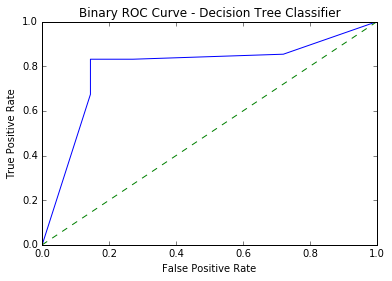

In [202]:
# Example referred to: http://scikit-learn.org/0.15/auto_examples/plot_roc.html
from sklearn.metrics import roc_curve, auc

probabilities = clf.predict_proba(X_test)
scores = []
for [i, j] in probabilities:
    scores.append(j)
y_scores = np.array(scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'g--')
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

In [203]:
roc_auc

0.79199200152351934

As we can see from the above, the ROC curve generated from the decision tree classifier model gives out a reasonably good performance. The area covered under the ROC curve is 0.791.

The curve shape surprised me a little bit because I was expecting a more zig-zagged version, but considering the fact that I'm using the decision tree classifier, the curve shape makes more sense to me. Because if we look into the prediction probability values, the decision tree classifier gives out either [0, 1] value, instead of a faction value, so that may be the reason for such smoother shape.

#### Part 6: A Precision/Recall curve

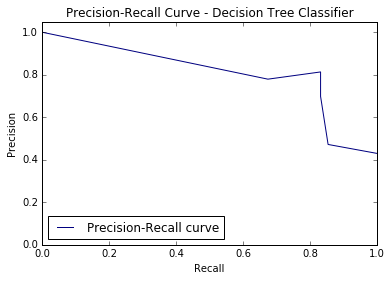

In [204]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
average_precision = average_precision_score(y_test, y_scores)

# Example referred to: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - Decision Tree Classifier')
plt.legend(loc="lower left")
plt.show()


In [205]:
average_precision

0.80400728530527321

The Precision-Recall Curve is defined by the precision and recall values. The recall axis is basically equivalent to TPR, which represents what portion of the true instances already captured. Precision (y axis) tells us the ratio of (true positive information / true information claimed so far). We still uses the rank scores used by the ROC curve, and start from the higher threshold to lower. PR curve then is generated as we go over each instance, just like what we did for ROC curve, with the only difference being we are using Precision and Recall as the x, y axis for measurements. 

The average_precision measures the area covered by the PR curve. In this case PR curve captured 0.80 / 1.0. So it's a reasonably good prediction model based on PR curve's point of view.

#### Part 7: Extra Exploration - Compare Gaussian NB with Decision Tree 

In the above experiment, I was using Decision Tree Classifier as the prediction model, and now I want to use another model (Gaussian Naive Bayes) to compare the resulting ROC curve and PR curve with the Decision Tree model.

In [206]:
clf_2 = GaussianNB()
db = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat'
df = pd.read_csv(db, header=None, sep=' ')
arr = df.values

features = arr[:,0:14]
classes = arr[:,14]

X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=0.3, random_state=0)

clf_2 = clf_2.fit(X_train, y_train)

In [217]:
num_total = num_correct = num_wrong = 0
predictions = clf_2.predict(X_test)
for i in xrange(len(predictions)):
    result = predictions[i]
    if result == y_test[i]:
        num_correct += 1
    else:
        num_wrong += 1
    num_total += 1
print 'Total number of testcases: %s \nTotal number of correct predictions: %s \nAccuracy: %f' % (num_total, num_correct, float(num_correct)/num_total)

Total number of testcases: 207 
Total number of correct predictions: 165 
Accuracy: 0.797101


In [218]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions,target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.75      0.96      0.84       118
    class 1       0.91      0.58      0.71        89

avg / total       0.82      0.80      0.79       207



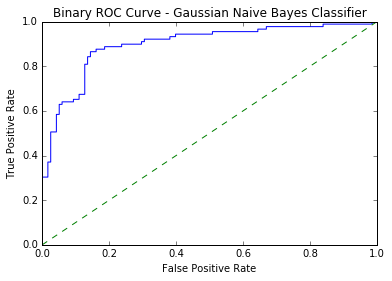

In [211]:
# Example referred to: http://scikit-learn.org/0.15/auto_examples/plot_roc.html
from sklearn.metrics import roc_curve, auc

probabilities = clf_2.predict_proba(X_test)
scores = []
for [i, j] in probabilities:
    scores.append(j)
y_scores = np.array(scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'g--')
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - Gaussian Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

In [208]:
roc_auc

0.89759093505998855

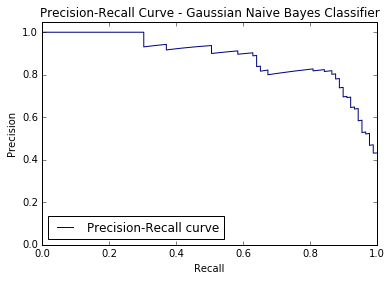

In [210]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
average_precision = average_precision_score(y_test, y_scores)

# Example referred to: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - Gaussian Naive Bayes Classifier')
plt.legend(loc="lower left")
plt.show()

In [212]:
average_precision

0.88184185941942439

#### Discovery

After doing the same experiment using Gaussian NB classifier, I found several interesting points. Firstly, Gaussian NB classifier has lower prediction accuracy and lower average precision / recall values compared to the Decision tree classifier. However interestingly, the ROC curve and PR curve for Gaussian NB captured a bigger area than that of the decision tree's. Secondly, the Gaussian NB classifier displays a more zig-zagged ROC and PR curve compared to the Decision Tree's curves.

In summary, evaluated from the above metrics, I think both classifiers are reasonably good prediction models for this specific dataset. 